# Assignment 3

Quentin Le Roux

<hr>
<hr>
<hr>

## Exercise 1

### Instructions

1. Read the following paper: https://arxiv.org/abs/1709.01449.

2. Write a summary of 1-2 pages.

### Answer

*Please see the .pdf file attached (2-page summary in the LNCS format)*

<hr>

## Exercise 2

### Instructions

1. **Fit a model to predict the diagnosis (DX) of the subjects using both AGE and APOE4 as predictors.**


2. **Consider subjects who are 80 years old and check the effect of the APOE4 gene on the diagnosis.**
    - <u>Hint:</u> You'll draw many samples from two binomial distributions. One where APOE4 is included in the computation of $p_i$ and one where it's not.
   

3. **In the last lesson, we fitted a model to predict the diagnosis using only the size of the brain (norm_brain). Compare this model and the one of question 1 in terms of WAIC. Is one better than the other?**

### Answer

#### Library Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystan
import seaborn as sns

from pystan.constants import MAX_UINT
from scipy.stats import binom
from scipy.special import logsumexp

pd.set_option('mode.chained_assignment', None)

#### Function declarations

In [2]:
def data_import() -> pd.DataFrame:
    """
    Imports the dataset used in class, located in the
    'adni_data' file.
    """
    # Imports the data
    data = pd.read_csv('adni_data')
    # Extracts the datapoints of interest
    data_ct_ad = data.query('DX == 1 | DX == 3') 
    # Reformats the data
    data_ct_ad['DX'] = data_ct_ad['DX'].map({1: 0, 3: 1})
    data_ct_ad['norm_brain'] = data_ct_ad['WholeBrain.bl'] / \
                               data_ct_ad['ICV']
    data_ct_ad['norm_brain'] = (data_ct_ad['norm_brain'] - \
                                np.mean(data_ct_ad['norm_brain'])) / \
                                np.std(data_ct_ad['norm_brain'])
    # Removes NA and returns the data
    data_ct_ad.dropna(inplace = True)
    return data_ct_ad

def print_95CI_param(
    pystan_model: pystan.model, 
    parameter: str
) -> None:
    """
    Prints the 95% confidence interval of a given parameter after 
    being fitted as part of a pystan model.
    """
    quantiles = np.quantile(pystan_model.extract()[parameter],
                            [0.025, 0.5, 0.975])
    print(f"95% confidence interval for parameter {parameter}:",
          f"2.5% threshold:\t\t{quantiles[0]}",
          f"mean:\t\t\t{quantiles[1]}",
          f"97.5% threshold:\t{quantiles[2]}",
          sep="\n")

def print_probability_increase(
    posterior: pystan.model, 
    title: str, 
    name_variable: str ="APOE4 gene"
) -> None:
    """
    Prints the baseline probability of a pystan posterior model
    and the probability increase per unit increase of a given covariate.
    """
    print(title)
    est_a = posterior.extract()["a"]
    quantiles_a = np.quantile(est_a, [0.05, 0.5, 0.95])
    est_b = posterior.extract()["b"]
    quantiles_b = np.quantile(est_b, [0.05, 0.5, 0.95])
    logistic_a_5 = np.exp(quantiles_a[0])/(1 + np.exp(quantiles_a[0]))
    logistic_a_50 = np.exp(quantiles_a[1])/(1 + np.exp(quantiles_a[1]))
    logistic_a_95 = np.exp(quantiles_a[2])/(1 + np.exp(quantiles_a[2]))
    print("Baseline probability of disease:")
    print("5%  :", logistic_a_5)
    print("50% :", logistic_a_50)
    print("95% :", logistic_a_95)
    logistic_b_5 = np.exp(quantiles_a[0] + quantiles_b[0]) / \
                   (1 + np.exp(quantiles_a[0] + quantiles_b[0]))
    logistic_b_50 = np.exp(quantiles_a[0] + quantiles_b[1]) / \
                    (1 + np.exp(quantiles_a[0] + quantiles_b[1]))
    logistic_b_95 = np.exp(quantiles_a[0] + quantiles_b[2]) / \
                    (1 + np.exp(quantiles_a[0] + quantiles_b[2]))
    print(f"Probability increase for unit increase in {name_variable}",
          "expression (parameter 'a' at lowest quantile):")
    print("5%  :", logistic_b_5)
    print("50% :", logistic_b_50)
    print("95% :", logistic_b_95); print("\n")
    
def run_pystan_modeling(
    data: pd.DataFrame, 
    model: str, 
    model_data: dict, 
    params_to_plot: list,
    sampling_size = 1000
) -> tuple:
    """
    Compiles a pystan model and runs it on a given dataset and parameters.
    Outputs the boxplot distribution of the generated parameters, and returns
    the generated posterior and WAIC of the model (for comparison).
    """
    # Compiles and fit the model
    stan_model = pystan.StanModel(model_code = model)
    posterior = stan_model.sampling(data=model_data, seed=int(1), 
                                    iter=4000, chains=4)
    # Prints the diagnosis of the fit
    print(f"Post-fitting diagnosis:\n{pystan.check_hmc_diagnostics(posterior)}")
    # Computes the WAIC of the model
    p_i = posterior.extract()['p_i']
    lppd = []; pwaic = []
    for k in range(len(data)):
        id_log_lik = [binom.logpmf(data['DX'].values[k], 1, p_i[i,k]) 
                      for i in range(sampling_size)]
        lppd.append(logsumexp(id_log_lik) - np.log(len(id_log_lik)))
        pwaic.append(np.var(id_log_lik))
    waic = -2 * (np.sum(lppd) - np.sum(pwaic))
    # Plots the distribution of the parameters
    estimators = [posterior.extract()[param] for param in params_to_plot]
    yticks_values = [i+1 for i in range(len(params_to_plot))]
    plt.boxplot(estimators, vert=0)
    plt.yticks(yticks_values, params_to_plot)
    plt.axvline(x=0, color="black", alpha=0.1)
    plt.title(f"Posterior distribution of parameters: {params_to_plot}")
    plt.show()
    # Returns the posterior model and the WAIC
    return posterior, waic

#### Data import

In [3]:
data = data_import()
data.head()

,RID,APOE4,DX,AGE,WholeBrain.bl,ICV,norm_brain
0,2,0.0,0,74.3,1229738.0,1.984657e+06,-0.907716
1,3,1.0,1,81.3,1129834.0,1.920691e+06,-1.508346
3,5,0.0,0,73.7,1116633.0,1.640766e+06,0.258629
5,7,1.0,1,75.4,875798.0,1.353519e+06,-0.382669
6,8,0.0,0,84.5,948684.0,1.396068e+06,0.239182


In [4]:
data.describe()

,RID,APOE4,DX,AGE,WholeBrain.bl,ICV,norm_brain
count,826.000000,826.000000,826.000000,826.000000,8.260000e+02,8.260000e+02,826.000000
mean,2686.322034,0.525424,0.388620,74.451574,1.011453e+06,1.521185e+06,-0.001905
std,2062.148046,0.658710,0.487732,6.648689,1.113623e+05,1.680556e+05,1.000892
min,2.000000,0.000000,0.000000,55.100000,7.274780e+05,1.100687e+06,-2.765395
25%,673.250000,0.000000,0.000000,70.500000,9.329465e+05,1.396231e+06,-0.719043
50%,2718.000000,0.000000,0.000000,74.150000,1.008351e+06,1.504898e+06,0.022915
75%,4690.500000,1.000000,1.000000,78.900000,1.087573e+06,1.634110e+06,0.684545
max,5296.000000,2.000000,1.000000,90.900000,1.486036e+06,2.057399e+06,3.236658


In [5]:
data.shape

(826, 7)

We plot the kernel density estimators of the `AGE` and `APOE4` variables and note that their distribution are very different. If `AGE` can somewhat be approximated by a normal distribution, that is not really the case with `APOE4`, which is discretely parametrized. 

This is interesting with regards to how we can model the coefficient of `APOE4` as part of a Bayesian modeling process. We will try to go beyond approximating its coefficient with a normal prior and explore/try different distributions to see whether we observe improvements.

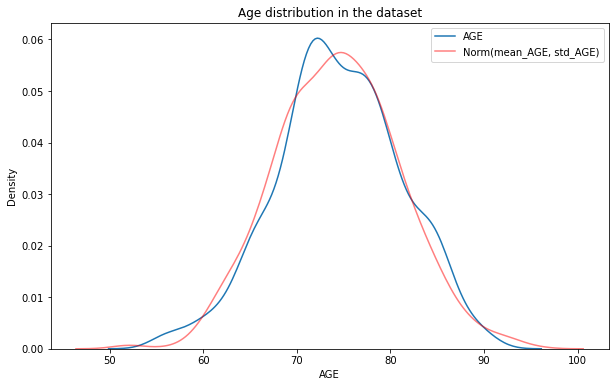

In [6]:
plt.figure(figsize=(10,6))
sns.kdeplot(data["AGE"], label="AGE").set(title='Age distribution in the dataset')
sns.kdeplot(np.random.normal(data["AGE"].mean(), data["AGE"].std(), 1000),
            label="Norm(mean_AGE, std_AGE)",color="red", alpha=0.5)
plt.legend()
plt.show()

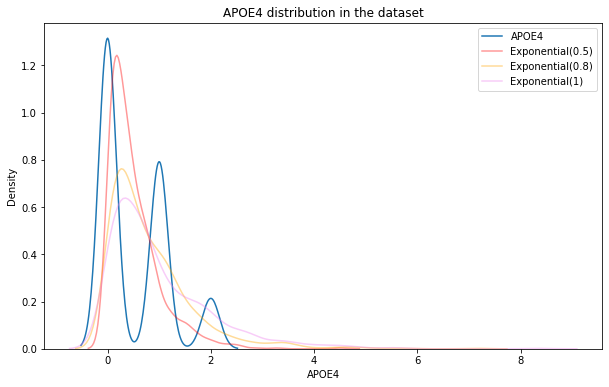

In [7]:
plt.figure(figsize=(10,6))
sns.kdeplot(data["APOE4"], label="APOE4").set(title='APOE4 distribution in the dataset')
sns.kdeplot(np.random.exponential(0.5, 1000),
            label="Exponential(0.5)",color="red", alpha=0.4)
sns.kdeplot(np.random.exponential(0.8, 1000),
            label="Exponential(0.8)",color="orange", alpha=0.4)
sns.kdeplot(np.random.exponential(1, 1000),
            label="Exponential(1)",color="violet", alpha=0.4)
plt.legend()
plt.show()

<hr>

#### <u>Question 1: Building a model `DX ~ AGE + APOE4`</u>

<u>Goal:</u> We will try a Markov Chain Monte Carlo (MCMC) approach to approximate the distribution of through sampling.

- <u>Note 1, HMC:</u> We will try to conform to the Hamiltonian Monte Carlo (HMC) approach as seen in class instead of the classical *Metropolis-Hastings* MCMC method (where an iterative 2-step process is repeated where the current parameter space is perturbed to provide a proposal that is rejected, i.e. corrected, if it is deemed too implausible). As stated in class:

    > HMC's basic idea consists in better exploring a target distribution by leveraging the geometric properties of the distribution itself. Conceptually, speed and direction are defined such that we move across the parameter space with the differential properties of the target distribution. Thus defined, the set of dynamical systems describes the trajectory to follow (Hamiltonian dynamics).
    >
    > Example with a Gaussian model:
\begin{align}
Y&\sim\mathcal{N}(\mu,\sigma^2)\\
\mu&\sim\mathcal{N}(\mu_0,\sigma_0^2)\tag{prior}\\
\sigma&\sim\mathcal{U}(\text{bound}_\text{lower},\text{bound}_\text{upper})\tag{prior}\\
\text{With}&,\\
Y_i&\sim\mathcal{N}(\mu_i,\sigma^2)\tag{likelihood}\\
\mu_i&=\mu(x_i)\text{  s.t.  }\mu(x) = a+b.x\\
a&\sim\mathcal{N}(\mu_a,\sigma_a^2)\tag{prior}\\
b&\sim\mathcal{N}(\mu_b,\sigma_b^2\tag{prior}\\
\text{And}&,\\
\mathbb{P}(a,b,\sigma|Y,X)&=\mathbb{P}(Y|a,b,\sigma,X).\mathbb{P}(a).\mathbb{P}(b).\mathbb{P}(\sigma)
\end{align}

- <u>Note 2, PyStan:</u> For the purpose of this exercise, HMC will be implemented with the 2.xx version of the Python interface of the Stan library (https://mc-stan.org, https://pystan.readthedocs.io/en/latest/). The library has since been updated to a 3.xx version that does not provide backward compatibility. Moreover, the 2.xx PyStan library requires a GCC version older than 11. This can be dealt two ways: 

    1. either by forcing a Jupyter notebook to use an older version of GCC, 
    2. or by setting up an environment with an older Python version that does not ship with GCC11.
 
Running this exercise locally, ***the second option was chosen***.

    + version 1:
```Python
import os, pystan
from pystan.constants import MAX_UINT

os.environ["CC"] = "g++-10"
os.environ["CXX"] = "g++-10"
```

    + version 2:

```sh
$ conda create -n pystan_env python=3.6 ipykernel matplotlib seaborn scipy numpy pandas pystan=2.19.0.0
$ conda activate pystan_env
```

<u>Process:</u>

We are in a classification modeling setup where we want to estimate the probability of a patient having Alzheimer's disease. Having the disease or not corresponds to classes (e.g. 0 or 1). In such a setup, where we want to estimate $y$ the probabilty of being affected, the Binomial model is the most fitting one here s.t.:

\begin{align}
\mathbb{P}(y)&\sim\mathcal{B}(n,p),\,\text{a binomial likelihood model}\\
\text{with}&,\\
p&,\,\text{the probability of a patient being diagnosed with Alzheimer's disease}\\
y&,\,\text{the number of positive cases}\\
n&,\,\text{the number of trials/individuals}
\end{align}

In the following case, we will use the Binomial distribution for our likelihood model. A 1-predictor Binomial model is parametrized by the probability $p$ itself parametrized as a linear combination of the predictor $x$ s.t.:

\begin{align}
y_i &\sim \mathcal{B}(n, p_i)\\
f(p_i) &= a + b x_i
\end{align}

As noted in class, there are some issues to account for: 

- Since the probability $p_i$ must be bounded in the interval $[0,1]$, parameterizing it directly with a linear model will likely result in breaking the basic rules of probabilities.
- We have no guarantee at the moment that the linear $f(p_i)$ combination is bounded in the interval $[0,1]$.
- As such, the probability $p_i$ must be adapted to be contained in the interval $[0,1]$ via a link function: 
    - The logit which, when included as below, can be rewritten into a new, convenient estimation of $p_i$:

\begin{align}
logit(p_i) &= \log(\frac{p_i}{1-p_i})\\
\log(\frac{p_i}{1-p_i}) &= a + b x_i\\
p_i &= \frac{\exp(a + b x_i)}{1 + \exp(a + b x_i)}
\end{align}

In our case, We want to fit the dependent variable `DX` with the covariates `AGE` and `APOE4`. As such, we are interested in a logistic regression model for predicting Alzheimer's disease given two predictors $x$ and $z$ s.t.:

\begin{align}
y_i &\sim \mathcal{B}(n, p_i)\\
p_i &= \frac{\exp(a + b x_i + c z_i)}{1 + \exp(a + b x_i + c z_i)}
\end{align}

For exploration and comparison purposes, we will start with fitting `DX` with `AGE` and `APOE4` separately.

<u>Fitting `DX` with `AGE` and `APOE4` separately:</u>

At first we start by fitting each covariate separately with "DX" to see their individual effects. The given model for $p_i$ (to declare with pystan) is the same for both cases: 

\begin{align}
p_i &= \frac{\exp(a + b x_i)}{1 + \exp(a + b x_i)}
\end{align}

<span style="color:red">Of note</span>, as noted in our data import section, `APOE4` is discretely valued (either 0, 1, or 2) and we want to try to see the effect of different distributions for its coefficient. As such we will test either a normal, uniform, or exponential prior distribution to model the coefficient with the following parameters:

| prior distribution | parameters | 
| :---: | :---: |
| Normal | $\mu=0$, $\sigma=10$ |
| Uniform | lower $=0$, upper $=2$ |
| Exponential | $\lambda=1$ |

In [8]:
# Declares the pystan model for both:
#    - DX ~ AGE
#    - DX ~ APOE4
model = """
data {
  int<lower=1> N;
  int y[N];
  real x[N];
  real param1_a;
  real<lower=0> param2_a;
  real param1_b;
  real<lower=0> param2_b;
}
parameters {
  real a;
  real b;
}
transformed parameters {
  vector[N] p_i;
  for (i in 1:N) {
    p_i[i] = exp(a + b * x[i])/(1 + exp(a + b * x[i])); 
    }
}
"""

model_addon_AGE = """
model {
  a ~ normal(param1_a, param2_a);
  b ~ normal(param1_b, param2_b);
  y ~ binomial(1, p_i);
}
"""
model_addon_APOE4_normal = """
model {
  a ~ normal(param1_a, param2_a);
  b ~ normal(param1_b, param2_b); 
  y ~ binomial(1, p_i);
}
"""
model_addon_APOE4_uniform = """
model {
  a ~ normal(param1_a, param2_a);
  b ~ uniform(param1_b, param2_b); 
  y ~ binomial(1, p_i);
}
"""
model_addon_APOE4_exponential = """
model {
  a ~ normal(param1_a, param2_a);
  b ~ exponential(param1_b); 
  y ~ binomial(1, p_i);
}
"""

# Declares the data to send to the pystan model for
# both covariates AGE and APOE4
stan_data_AGE = {"x":        data["AGE"],
                 "y":        data['DX'],
                 "param1_a": 0,  "param2_a": 10,
                 "param1_b": 60, "param2_b": 10,
                 "N":        data.shape[0]
                }

stan_data_APOE4 = {"x":        data["APOE4"],
                   "y":        data['DX'],
                   "param1_a": 0, "param2_a": 10,
                   "N":        data.shape[0]
                  }

APOE4_normal = {"param1_b": 0, "param2_b": 10}
APOE4_uniform = {"param1_b": 0, "param2_b": 2}
# param2_b will not be used but still evaluated by pystan
# so we still need to declare it
APOE4_exponential ={"param1_b": 1, "param2_b": 1} 

We now run our modeling on each covariates.

1. pystan model run for DX ~ AGE

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_62803ab0ce3a609de8e59ec3a2120226 NOW.


Post-fitting diagnosis:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


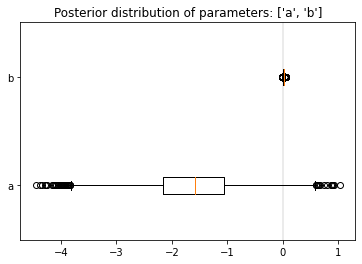

In [9]:
posterior_AGE, waic_AGE = run_pystan_modeling(
    data, model+model_addon_AGE, stan_data_AGE, ["a", "b"]
)

2. pystan model run for DX ~ APOE4 with APOE4 described by a prior normal distribution

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0a22f20705718a96016e1cb4dce21872 NOW.


Post-fitting diagnosis:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


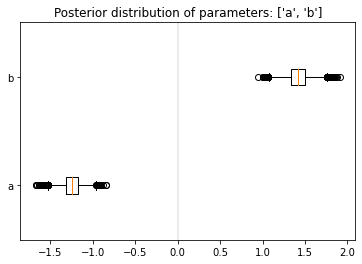

In [10]:
posterior_APOE4_normal, waic_APOE4_normal = run_pystan_modeling(
    data, model+model_addon_APOE4_normal, 
    {**stan_data_APOE4, **APOE4_normal}, 
    ["a", "b"]
)

3. pystan model run for DX ~ APOE4 with APOE4 described by a prior uniform distribution

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_85a21e36d8d2e02751a59c2c93c0ba85 NOW.


Post-fitting diagnosis:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


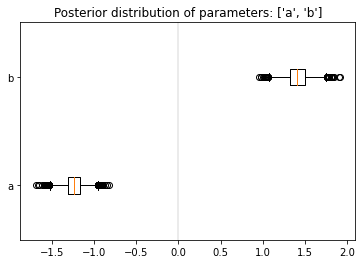

In [11]:
posterior_APOE4_uniform, waic_APOE4_uniform = run_pystan_modeling(
    data, model+model_addon_APOE4_uniform, 
    {**stan_data_APOE4, **APOE4_uniform}, 
    ["a", "b"]
)

4. pystan model run for DX ~ APOE4 with APOE4 described by a prior exponential distribution

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_30b7facd74674540213bbb4179e0868a NOW.


Post-fitting diagnosis:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


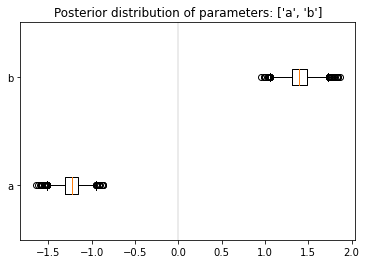

In [12]:
posterior_APOE4_exponential, waic_APOE4_exponential = run_pystan_modeling(
    data, model+model_addon_APOE4_exponential, 
    {**stan_data_APOE4, **APOE4_exponential}, 
    ["a", "b"]
)

We print the posterior results for each model for visualization purposes:

In [13]:
posterior_AGE


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_62803ab0ce3a609de8e59ec3a2120226.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        -1.62    0.03   0.83  -3.26  -2.17  -1.59  -1.07  -0.01   1026   1.01
b         0.02  3.4e-4   0.01-5.8e-3 8.3e-3   0.02   0.02   0.04   1037   1.01
p_i[1]    0.39  2.0e-4   0.02   0.35   0.38   0.39    0.4   0.42   7178    1.0
p_i[2]    0.41  5.3e-4   0.02   0.37    0.4   0.41   0.43   0.46   2184    1.0
p_i[3]    0.39  2.2e-4   0.02   0.35   0.37   0.39    0.4   0.42   6121    1.0
p_i[4]    0.39  2.0e-4   0.02   0.36   0.38   0.39    0.4   0.43   7263    1.0
p_i[5]    0.43  7.9e-4   0.03   0.36    0.4   0.43   0.45   0.49   1616    1.0
p_i[6]    0.39  2.1e-4   0.02   0.35   0.37   0.39    0.4   0.42   6595    1.0
p_i[7]     0.4  3.2e-4   0.02   0.36   0.39    0.4   0.42   

In [14]:
posterior_APOE4_normal


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_0a22f20705718a96016e1cb4dce21872.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        -1.25  2.0e-3   0.11  -1.46  -1.31  -1.24  -1.17  -1.04   2852    1.0
b         1.42  2.4e-3   0.13   1.17   1.33   1.42    1.5   1.68   2877    1.0
p_i[1]    0.22  3.4e-4   0.02   0.19   0.21   0.22   0.24   0.26   2862    1.0
p_i[2]    0.54  2.8e-4   0.02   0.49   0.53   0.54   0.56   0.59   7347    1.0
p_i[3]    0.22  3.4e-4   0.02   0.19   0.21   0.22   0.24   0.26   2862    1.0
p_i[4]    0.54  2.8e-4   0.02   0.49   0.53   0.54   0.56   0.59   7347    1.0
p_i[5]    0.22  3.4e-4   0.02   0.19   0.21   0.22   0.24   0.26   2862    1.0
p_i[6]    0.54  2.8e-4   0.02   0.49   0.53   0.54   0.56   0.59   7347    1.0
p_i[7]    0.22  3.4e-4   0.02   0.19   0.21   0.22   0.24   

In [15]:
posterior_APOE4_uniform


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_85a21e36d8d2e02751a59c2c93c0ba85.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        -1.24  2.0e-3   0.11  -1.46  -1.32  -1.24  -1.17  -1.04   2856    1.0
b         1.41  2.3e-3   0.13   1.17   1.33   1.41    1.5   1.66   2906    1.0
p_i[1]    0.22  3.5e-4   0.02   0.19   0.21   0.22   0.24   0.26   2851    1.0
p_i[2]    0.54  2.8e-4   0.02    0.5   0.53   0.54   0.56   0.59   7460    1.0
p_i[3]    0.22  3.5e-4   0.02   0.19   0.21   0.22   0.24   0.26   2851    1.0
p_i[4]    0.54  2.8e-4   0.02    0.5   0.53   0.54   0.56   0.59   7460    1.0
p_i[5]    0.22  3.5e-4   0.02   0.19   0.21   0.22   0.24   0.26   2851    1.0
p_i[6]    0.54  2.8e-4   0.02    0.5   0.53   0.54   0.56   0.59   7460    1.0
p_i[7]    0.22  3.5e-4   0.02   0.19   0.21   0.22   0.24   

In [16]:
posterior_APOE4_exponential


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_30b7facd74674540213bbb4179e0868a.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        -1.23  2.0e-3    0.1  -1.44   -1.3  -1.23  -1.16  -1.03   2823    1.0
b          1.4  2.3e-3   0.13   1.15   1.31    1.4   1.48   1.65   2874    1.0
p_i[1]    0.23  3.4e-4   0.02   0.19   0.21   0.23   0.24   0.26   2814    1.0
p_i[2]    0.54  2.7e-4   0.02    0.5   0.52   0.54   0.56   0.59   7563    1.0
p_i[3]    0.23  3.4e-4   0.02   0.19   0.21   0.23   0.24   0.26   2814    1.0
p_i[4]    0.54  2.7e-4   0.02    0.5   0.52   0.54   0.56   0.59   7563    1.0
p_i[5]    0.23  3.4e-4   0.02   0.19   0.21   0.23   0.24   0.26   2814    1.0
p_i[6]    0.54  2.7e-4   0.02    0.5   0.52   0.54   0.56   0.59   7563    1.0
p_i[7]    0.23  3.4e-4   0.02   0.19   0.21   0.23   0.24   

Then for good measure, we check the 95% confidence interval for the covariate parameter $b$ for each case. Then we print the WAIC for the models.

In [17]:
print_95CI_param(posterior_AGE, "b")

95% confidence interval for parameter b:
2.5% threshold:		-0.005760985249977022
mean:			0.015266232546939356
97.5% threshold:	0.03751923825277569


In [18]:
print_95CI_param(posterior_APOE4_normal, "b")

95% confidence interval for parameter b:
2.5% threshold:		1.1708533204166809
mean:			1.4155808268649908
97.5% threshold:	1.6771829829574263


In [19]:
print_95CI_param(posterior_APOE4_uniform, "b")

95% confidence interval for parameter b:
2.5% threshold:		1.1735692928454866
mean:			1.4140803319405102
97.5% threshold:	1.6636629069660802


In [20]:
print_95CI_param(posterior_APOE4_exponential, "b")

95% confidence interval for parameter b:
2.5% threshold:		1.15148617544782
mean:			1.3978513865738318
97.5% threshold:	1.6462105625189034


In [21]:
print(f"WAIC of model DX ~ AGE: \t\t{waic_AGE}",
      f"WAIC of model DX ~ APOE4 (normal):\t{waic_APOE4_normal}",
      f"WAIC of model DX ~ APOE4 (uniform):\t{waic_APOE4_uniform}",
      f"WAIC of model DX ~ APOE4 (exponential):\t{waic_APOE4_exponential}",
      sep="\n")

WAIC of model DX ~ AGE: 		1106.080628367538
WAIC of model DX ~ APOE4 (normal):	960.7398801041145
WAIC of model DX ~ APOE4 (uniform):	960.8239647409292
WAIC of model DX ~ APOE4 (exponential):	960.54554312265


<u>Observations on fitting `DX` with either `AGE` and `APOE4`:</u>

Reflected by the WAIC, we observe that the covariate `APOE4` has a better predictive value than `AGE` (`AGE`'s 95% confidence interval straddles over both positive and negative values). This is reinforced by the visual use of boxplots that shows `AGE`'s confidence interval being squished close to the 0-line. As such, were we to want to use only a single covariate, we would likely go with `APOE4`.

By looking at different prior distributions for `APOE4`, we find that changing the distribution does not specifically impact the posterior results in terms of WAIC. Using the exponential distribution only resulted in a minute improvement over the normal distribution.

<u>Interpretation of why `AGE` is a poor predictor:</u>

By looking at the kernel density estimator plot seen above in the data import section, and drawing on prior knowledge that Alzheimer's disease is a neurodegenerative disease that usually only appears in old age, we see that the dataset we're using only contains patients within the 55 to 91 age range. This may indicate that the `AGE` variable does not provide any predictive value on its own with regards to a Alzheimer's disease diagnosis for the patients included in the ADNI dataset. More succintly, since all patients' ages fall within the interval where we would expect the onset of the illness, using `AGE` as a covariate might not provide any valuable input in a Bayesian workflow (when taken without any other conditions).

<u>Fitting `DX` with both `AGE` and `APOE4`:</u>

Finaly, to answer the original question, we are interested in fitting a model that takes both covariates into account. We go through the same workflow as above.


<span style="color:red">Of note</span>, as previously with the model where we only had `APOE4` for covariate, we will model `DX ~ AGE + APOE4` using a normal, uniform, or exponential prior distribution for the `APOE4` variable and see what happens.

In [22]:
# Declares the pystan model for DX ~ AGE + APOE4
model_2preds = """
data {
  int<lower=1> N;
  int y[N];
  real x[N];
  real z[N];
  real param1_a;
  real<lower=0> param2_a;
  real param1_b;
  real<lower=0> param2_b;
  real param1_c;
  real<lower=0> param2_c;
}
parameters {
  real a;
  real b;
  real c;
}
transformed parameters {
  vector[N] p_i;
  for (i in 1:N) {
    p_i[i] = exp(a + b * x[i] + c * z[i])/(1 + exp(a + b * x[i] + c * z[i])); 
    }
}
"""

model_addon_2preds_normal = """
model {
  a ~ normal(param1_a, param2_a);
  b ~ normal(param1_b, param2_b); 
  c ~ normal(param1_c, param2_c);
  y ~ binomial(1, p_i);
}
"""
model_addon_2preds_uniform = """
model {
  a ~ normal(param1_a, param2_a);
  b ~ uniform(param1_b, param2_b); 
  c ~ normal(param1_c, param2_c);
  y ~ binomial(1, p_i);
}
"""
model_addon_2preds_exponential = """
model {
  a ~ normal(param1_a, param2_a);
  b ~ exponential(param1_b); 
  c ~ normal(param1_c, param2_c);
  y ~ binomial(1, p_i);
}
"""

# Declares the data to send to the pystan model
stan_data_2preds = {
    "x":        data["APOE4"],
    "z":        data["AGE"],
    "y":        data['DX'],
    "param1_a": 0, "param2_a": 10,
    "param1_c": 60, "param2_c": 10,
    "N":        data.shape[0]
}

We now run our modeling on each covariates.

1. pystan model run for DX ~ AGE + APOE4 with APOE4 described by a prior normal distribution

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb2987f379b5b1b492ed7f6a4c776bb8 NOW.


Post-fitting diagnosis:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


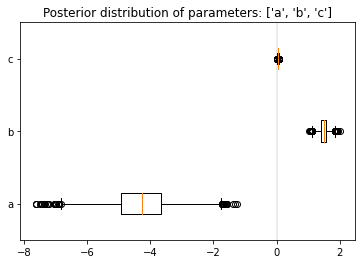

In [23]:
posterior_2preds_normal, waic_2preds_normal = run_pystan_modeling(
    data, model_2preds+model_addon_2preds_normal, 
    {**stan_data_2preds, **APOE4_normal}, 
    ["a", "b", "c"]
)

2. pystan model run for DX ~ AGE + APOE4 with APOE4 described by a prior uniform distribution

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ed63c54fd42515dbbbf00aabdb962037 NOW.


Post-fitting diagnosis:
{'n_eff': True, 'Rhat': True, 'divergence': False, 'treedepth': True, 'energy': True}


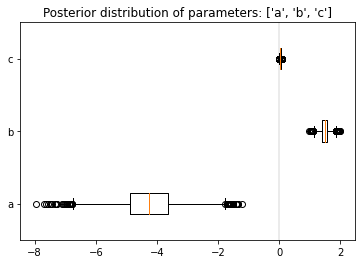

In [24]:
posterior_2preds_uniform, waic_2preds_uniform = run_pystan_modeling(
    data, model_2preds+model_addon_2preds_uniform, 
    {**stan_data_2preds, **APOE4_uniform}, 
    ["a", "b", "c"]
)

The model's iterations yield some divergences compared to the one where the prior normal distribution was used for the `APOE4` data.

3. pystan model run for DX ~ AGE + APOE4 with APOE4 described by a prior exponential distribution

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_676afaacf5c2a7601b0f154ad92195cf NOW.


Post-fitting diagnosis:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


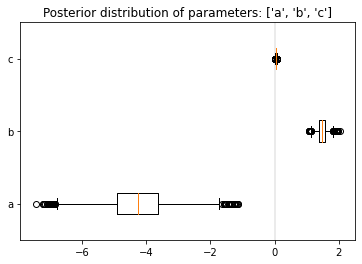

In [25]:
posterior_2preds_exponential, waic_2preds_exponential = run_pystan_modeling(
    data, model_2preds+model_addon_2preds_exponential, 
    {**stan_data_2preds, **APOE4_exponential}, 
    ["a", "b", "c"]
)

Sometimes, this model's iterations yield some divergences compared to the one where the prior normal distribution was used for the `APOE4` data.

We now print the posterior results for each model for visualization purposes:

In [26]:
posterior_2preds_normal


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_bb2987f379b5b1b492ed7f6a4c776bb8.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        -4.28    0.02   0.93   -6.1  -4.93  -4.26  -3.66  -2.48   2559    1.0
b         1.49  2.5e-3   0.13   1.24    1.4   1.49   1.58   1.76   2827    1.0
c         0.04  2.4e-4   0.01   0.02   0.03   0.04   0.05   0.06   2588    1.0
p_i[1]    0.22  2.9e-4   0.02   0.18    0.2   0.21   0.23   0.25   4036    1.0
p_i[2]    0.62  5.2e-4   0.03   0.55   0.59   0.62   0.64   0.68   3583    1.0
p_i[3]    0.21  3.0e-4   0.02   0.18    0.2   0.21   0.22   0.25   3895    1.0
p_i[4]    0.56  3.3e-4   0.02   0.51   0.54   0.56   0.57   0.61   5240    1.0
p_i[5]    0.29  4.9e-4   0.03   0.23   0.27   0.29   0.31   0.35   3807    1.0
p_i[6]    0.54  3.2e-4   0.02    0.5   0.53   0.54   0.56   

In [27]:
posterior_2preds_uniform


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_ed63c54fd42515dbbbf00aabdb962037.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        -4.27    0.02   0.92  -6.07  -4.89  -4.26  -3.64  -2.48   2371    1.0
b         1.49  2.4e-3   0.13   1.23    1.4   1.49   1.58   1.75   3132    1.0
c         0.04  2.5e-4   0.01   0.02   0.03   0.04   0.05   0.06   2385    1.0
p_i[1]    0.22  2.7e-4   0.02   0.18    0.2   0.21   0.23   0.25   4583    1.0
p_i[2]    0.61  5.5e-4   0.03   0.55   0.59   0.62   0.64   0.68   3274    1.0
p_i[3]    0.21  2.8e-4   0.02   0.18    0.2   0.21   0.22   0.25   4399    1.0
p_i[4]    0.56  3.4e-4   0.02   0.51   0.54   0.56   0.57   0.61   5148    1.0
p_i[5]    0.29  5.1e-4   0.03   0.24   0.27   0.29   0.31   0.35   3606    1.0
p_i[6]    0.54  3.2e-4   0.02    0.5   0.53   0.54   0.56   

In [28]:
posterior_2preds_exponential


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_676afaacf5c2a7601b0f154ad92195cf.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        -4.27    0.02   0.93   -6.1   -4.9  -4.25  -3.63  -2.43   2479    1.0
b         1.48  2.4e-3   0.13   1.23   1.39   1.48   1.56   1.73   2917    1.0
c         0.04  2.4e-4   0.01   0.02   0.03   0.04   0.05   0.06   2510    1.0
p_i[1]    0.22  2.9e-4   0.02   0.18    0.2   0.22   0.23   0.25   4089    1.0
p_i[2]    0.61  5.5e-4   0.03   0.55   0.59   0.61   0.64   0.67   3225    1.0
p_i[3]    0.21  2.9e-4   0.02   0.18    0.2   0.21   0.22   0.25   3914    1.0
p_i[4]    0.56  3.4e-4   0.02   0.51   0.54   0.56   0.57    0.6   4968    1.0
p_i[5]    0.29  4.9e-4   0.03   0.24   0.27   0.29   0.31   0.36   3829    1.0
p_i[6]    0.54  3.3e-4   0.02    0.5   0.53   0.54   0.56   

For all three models resulting from varying the prior distribution of `APOE4`, we check the 95% confidence interval for the covariate parameters $b$ and $c$. Then we print the WAIC for the model `DX ~ AGE + APOE4` compared to the previously computed ones.

In [29]:
print_95CI_param(posterior_2preds_normal, "b"); print("\n")
print_95CI_param(posterior_2preds_normal, "c")

95% confidence interval for parameter b:
2.5% threshold:		1.2434335392003992
mean:			1.4876169793520257
97.5% threshold:	1.7560004769072486


95% confidence interval for parameter c:
2.5% threshold:		0.016415482049762436
mean:			0.039892958973839904
97.5% threshold:	0.06377668833070309


In [30]:
print_95CI_param(posterior_2preds_uniform, "b"); print("\n")
print_95CI_param(posterior_2preds_uniform, "c")

95% confidence interval for parameter b:
2.5% threshold:		1.2277715799651452
mean:			1.486197721589066
97.5% threshold:	1.7518551284605774


95% confidence interval for parameter c:
2.5% threshold:		0.016553632370611075
mean:			0.039827748635819976
97.5% threshold:	0.06348645114919177


In [31]:
print_95CI_param(posterior_2preds_exponential, "b"); print("\n")
print_95CI_param(posterior_2preds_exponential, "c")

95% confidence interval for parameter b:
2.5% threshold:		1.2276999405824787
mean:			1.4757879423237492
97.5% threshold:	1.7279033640905672


95% confidence interval for parameter c:
2.5% threshold:		0.016746536501951133
mean:			0.039817756808668225
97.5% threshold:	0.06420577081618001


In [32]:
print(f"WAIC of model DX ~ AGE: \t\t\t{waic_AGE}",
      f"WAIC of model DX ~ APOE4 (normal):\t\t{waic_APOE4_normal}",
      f"WAIC of model DX ~ APOE4 (uniform):\t\t{waic_APOE4_uniform}",
      f"WAIC of model DX ~ APOE4 (exponential):\t\t{waic_APOE4_exponential}",
      f"WAIC of model DX ~ AGE + APOE4 (normal):\t{waic_2preds_normal}",
      f"WAIC of model DX ~ AGE + APOE4 (uniform):\t{waic_2preds_uniform}",
      f"WAIC of model DX ~ AGE + APOE4 (exponential):\t{waic_2preds_exponential}",
      sep="\n")

WAIC of model DX ~ AGE: 			1106.080628367538
WAIC of model DX ~ APOE4 (normal):		960.7398801041145
WAIC of model DX ~ APOE4 (uniform):		960.8239647409292
WAIC of model DX ~ APOE4 (exponential):		960.54554312265
WAIC of model DX ~ AGE + APOE4 (normal):	951.9810056175705
WAIC of model DX ~ AGE + APOE4 (uniform):	952.3549200301862
WAIC of model DX ~ AGE + APOE4 (exponential):	951.853508141098


<u>Observations on fitting `DX` with both `AGE` and `APOE4`:</u>

When fitting the model with both covariates, and by looking at the WAIC metrics, we see a slight improvement on the model `DX ~ APOE4`. `APOE4` remains the most predictive of the two covariates.

Of note,
1. Fitting `APOE4` with a uniform prior distribution yields some divergences that impact that model's performance compared to using the exponential and normal distributions as priors for the variable (we note that sometimes, we also yielded divergences when using the exponential distribution but it's much raree)
2. In the `DX ~ AGE + APOE4` model, we see that the 95% confidence interval for the `AGE` coefficient now covers a strictly positive range now. This can be interpreted that, when `APOE4` is modeled with `AGE` as part of this model, we can be more confident that `AGE` becomes a positive (albeit very slightly) predictor of a Alzheimer's disease diagnosis:
    - Given [contextual knowledge](https://www.alzheimersorganization.org/alzheimers-gene-apoe4) and that the genetic mutation `APOE4` negatively affects the cleanup of plaques in the brain -- plaque build-up is associated with a Alzheimer's disease diagnosis --, we can propose that having the mutation increases the likelihood of developing Alzheimer's disease as one ages and grows further into old age, thus moving the `AGE` coefficient in the positive range.

<hr>

####  <u>Question 2: Effect of `APOE4` on 80-year-old patients</u>

We now consider patients who are stricly 80 years old. Given those select few patients (4, as seen below), we want to check the effect of the `APOE4` gene on their Alzheimer's disease diagnosis.

To do so, we will draw a large number of samples from two binomial distributions such that:

- one distribution does not have the `APOE4` data included in the computation of $p_i$ (we only model the intercept $a$)
- one where `APOE4` is included in the computation of $p_i$ (***here we will only try with the normal distribution as the previous question only displayed minute improvements***)
   
<u>Data extraction of 80-year-old patients:</u>

We start by extracting from the original dataset the subjects whose age is strictly 80. We find that the dataset only contains 4 of such patients, representing c. 0.5% of the total dataset. ***This is not much***. We also note that, out of 4 patients, only one is diagnosed with Alzheimer's disease.

In [33]:
data_80yo = data.query("AGE == 80")

In [34]:
data_80yo

,RID,APOE4,DX,AGE,WholeBrain.bl,ICV,norm_brain
139,230,0.0,0,80.0,1051053.0,1.714028e+06,-1.030522
489,866,0.0,0,80.0,943825.0,1.388961e+06,0.238778
522,920,1.0,0,80.0,946606.0,1.464818e+06,-0.398452
740,1285,1.0,1,80.0,1025968.0,1.626103e+06,-0.691147


<u>Fitting `DX` with `APOE4` and without on the restricted dataset:</u>

At first we start with fitting `DX` with the intercept only:

\begin{align}
p_i &= \frac{\exp(a)}{1 + \exp(a)}
\end{align}

Then we try fitting `DX` as we previously did with `APOE4`. We will reuse the previously stated model such that:

\begin{align}
p_i &= \frac{\exp(a + b x_i)}{1 + \exp(a + b x_i)}
\end{align}

In [35]:
model_intercept_only_80yo = """
data {
  int<lower=1> N;
  int y[N];
  real param1_a;
  real<lower=0> param2_a;
}
parameters {
  real a;
}
transformed parameters {
  vector[N] p_i;
  for (i in 1:N) {
    p_i[i] = exp(a)/(1 + exp(a)); 
    }
}
model {
  a ~ normal(param1_a, param2_a);
  y ~ binomial(1, p_i);
}
"""

stan_data_intercept_only_80yo = {
    "y":        data_80yo['DX'],
    "param1_a": 0, "param2_a": 10,
    "N":        data_80yo.shape[0]
}

stan_data_APOE4_80yo = {
    "x":        data_80yo["APOE4"],
    "y":        data_80yo['DX'],
    "param1_a": 0, "param2_a": 10,
    "N":        data_80yo.shape[0]
}

We now run our models.

1. pystan model run for DX ~ N.A (only the intercept)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_403ffda6040bb7c0cac5882765e5cefa NOW.


Post-fitting diagnosis:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


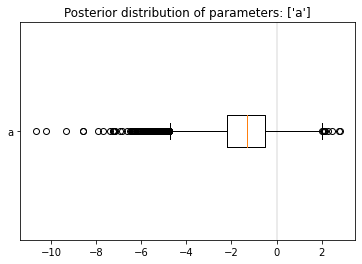

In [36]:
posterior_intercept_only_80yo, waic_intercept_only_80yo = run_pystan_modeling(
    data_80yo, model_intercept_only_80yo, 
    stan_data_intercept_only_80yo, ["a"],
    sampling_size=5000 # we increase the number of samples from 1000 to 5000
)

2. pystan model run for DX ~ APOE4 with APOE4 described by a prior normal distribution

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0a22f20705718a96016e1cb4dce21872 NOW.


Post-fitting diagnosis:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


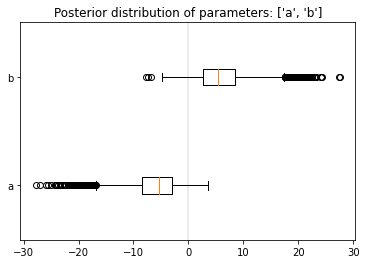

In [37]:
posterior_APOE4_normal_80yo, waic_APOE4_normal_80yo = run_pystan_modeling(
    data_80yo, model+model_addon_APOE4_normal, 
    {**stan_data_APOE4_80yo, **APOE4_normal}, 
    ["a", "b"],
    sampling_size=5000 # we increase the number of samples from 1000 to 5000
)

We print the posterior results for each model for visualization purposes:

In [38]:
posterior_intercept_only_80yo

Inference for Stan model: anon_model_403ffda6040bb7c0cac5882765e5cefa.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a       -1.43    0.03   1.36  -4.48  -2.21   -1.3  -0.52   0.91   2709    1.0
p_i[1]   0.26  3.5e-3   0.19   0.01    0.1   0.21   0.37   0.71   3045    1.0
p_i[2]   0.26  3.5e-3   0.19   0.01    0.1   0.21   0.37   0.71   3045    1.0
p_i[3]   0.26  3.5e-3   0.19   0.01    0.1   0.21   0.37   0.71   3045    1.0
p_i[4]   0.26  3.5e-3   0.19   0.01    0.1   0.21   0.37   0.71   3045    1.0
lp__    -2.81    0.01   0.77  -4.98  -3.01  -2.51  -2.31  -2.26   2927    1.0

Samples were drawn using NUTS at Thu Dec 16 20:43:18 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [39]:
posterior_APOE4_normal_80yo

Inference for Stan model: anon_model_0a22f20705718a96016e1cb4dce21872.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a       -6.08    0.13   4.23 -16.09   -8.5  -5.41   -2.9  -0.05   1069   1.01
b        5.89    0.13   4.46  -1.22    2.6   5.36   8.56  16.07   1163   1.01
p_i[1]   0.06  2.8e-3   0.13 1.0e-7 2.0e-4 4.5e-3   0.05   0.49   2249    1.0
p_i[2]   0.06  2.8e-3   0.13 1.0e-7 2.0e-4 4.5e-3   0.05   0.49   2249    1.0
p_i[3]   0.47  3.4e-3   0.29   0.02   0.22   0.46   0.71   0.96   7002    1.0
p_i[4]   0.47  3.4e-3   0.29   0.02   0.22   0.46   0.71   0.96   7002    1.0
lp__     -2.7    0.03   1.11  -5.68  -3.14  -2.37  -1.92   -1.6   1492    1.0

Samples were drawn using NUTS at Thu Dec 16 20:43:58 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on spli

For the two models (resulting from only taking the intercept, or using the normal distribution as prior for the covariate `APOE4`), we check the 95% confidence interval for the covariate parameters $a$ (for the intercept case) or $b$.

Then we print the WAIC for the model `DX ~ APOE4` and `DX` modeled with only the intercept for comparison purposes.

In [40]:
print_95CI_param(posterior_intercept_only_80yo, "a")

95% confidence interval for parameter a:
2.5% threshold:		-4.478393797562482
mean:			-1.3044496122625917
97.5% threshold:	0.9125265641146841


In [41]:
print_95CI_param(posterior_APOE4_normal_80yo, "a");print("")
print_95CI_param(posterior_APOE4_normal_80yo, "b")

95% confidence interval for parameter a:
2.5% threshold:		-16.08507499803026
mean:			-5.406708280540884
97.5% threshold:	-0.050826225331526344

95% confidence interval for parameter b:
2.5% threshold:		-1.2180361358245202
mean:			5.356588325597457
97.5% threshold:	16.070195400890903


In [42]:
est_a = posterior_intercept_only_80yo.extract()['a']
quantiles_a = np.quantile(est_a, [0.05, 0.5, 0.95])

logistic_a_5 = np.exp(quantiles_a[0])/(1 + np.exp(quantiles_a[0]))
logistic_a_50 = np.exp(quantiles_a[1])/(1 + np.exp(quantiles_a[1]))
logistic_a_95 = np.exp(quantiles_a[2])/(1 + np.exp(quantiles_a[2]))

print('Baseline probability of disease: \n')
print('5%  :', logistic_a_5)
print('50% :', logistic_a_50)
print('95% :', logistic_a_95)

Baseline probability of disease: 

5%  : 0.021204321041385737
50% : 0.21341710696696226
95% : 0.6351471781965288


In [43]:
print_probability_increase(
    posterior_APOE4_normal_80yo, 
    "Case with APOE4 modeled by a normal distribution:"
)

Case with APOE4 modeled by a normal distribution:
Baseline probability of disease:
5%  : 8.127234358276724e-07
50% : 0.0044663461060583595
95% : 0.3613733091501133
Probability increase for unit increase in APOE4 gene expression (parameter 'a' at lowest quantile):
5%  : 5.930126917307226e-07
50% : 0.0001722681803562652
95% : 0.5039277449716016




In [44]:
print(f"WAIC of model DX ~ n.a. (intercept only):\t{waic_intercept_only_80yo}",
      f"WAIC of model DX ~ APOE4 (normal):\t\t{waic_APOE4_normal_80yo}",
      sep="\n")

WAIC of model DX ~ n.a. (intercept only):	7.568616949014309
WAIC of model DX ~ APOE4 (normal):		7.054469122909131


<u>Observations on the impact of `APOE4` in predicting Alzheimer's disease in patients that are 80 years old:</u>

Using the WAIC measure, we see that including the `APOE4` variable with the prior normal distribution is positively impacting the accuracy of a prediction of Alzheimer's disease in patients that are 80 years old, i.e. the WAIC goes down. Because out of four patients, two have the gene and the diseased patient is a gene carrier, roughly speaking, knowing that a patient has a gene should improve the expected probability of having the disease for this sample of 80-year-old patients. 

Of note:
- Given the small amount of data (4 patients) and that only one out of four is actually diagnosed with the disease, adding the `APOE4` variable to the model seems limited in use. For instance on the `DX ~ APOE4` model, we find that the 95% confidence interval for the `APOE4` coefficient straddles positive and negative ranges.
- As such, we should be prudent about any conclusion here as the decrease in WAIC is only small and the probability increase for unit increase in `APOE4` gene expression seems to be skewed only at higher quantiles. We may have too few data points here to derive actual value from the subsample.

<hr>

####  <u>Question 3: Comparison between the models `DX ~ AGE + APOE4` and `DX ~ norm_brain`:</u>
 
We start with reproducing the model `DX ~ norm_brain` with `norm_brain` representing the size of the brain of a patient.

In [45]:
# Declares the data to send to the pystan model for
# the covariate norm_brain
stan_data_normbrain = {
    "x":        data["norm_brain"],
    "y":        data['DX'],
    "param1_a": 0, "param2_a": 10,
    "param1_b": 0, "param2_b": 10,
    "N":        data.shape[0]
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_62803ab0ce3a609de8e59ec3a2120226 NOW.


Post-fitting diagnosis:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


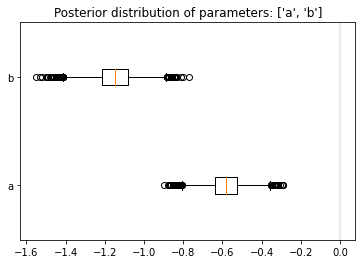

In [46]:
# pystan model run for DX ~ norm_brain
posterior_normbrain, waic_normbrain = run_pystan_modeling(
    data, model+model_addon_AGE, 
    stan_data_normbrain, ["a", "b"]
)

In [47]:
posterior_normbrain


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_62803ab0ce3a609de8e59ec3a2120226.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        -0.58  1.1e-3   0.08  -0.74  -0.64  -0.58  -0.52  -0.42   5542    1.0
b        -1.15  1.3e-3    0.1  -1.35  -1.22  -1.15  -1.08  -0.96   5370    1.0
p_i[1]    0.61  2.8e-4   0.03   0.56    0.6   0.61   0.63   0.66   8043    1.0
p_i[2]    0.76  3.3e-4   0.03    0.7   0.74   0.76   0.78   0.81   7185    1.0
p_i[3]    0.29  2.7e-4   0.02   0.26   0.28   0.29   0.31   0.33   4900    1.0
p_i[4]    0.46  2.4e-4   0.02   0.42   0.45   0.46   0.48    0.5   7182    1.0
p_i[5]     0.3  2.7e-4   0.02   0.26   0.29    0.3   0.31   0.34   4934    1.0
p_i[6]     0.2  2.8e-4   0.02   0.17   0.19    0.2   0.22   0.24   4571    1.0
p_i[7]     0.3  2.7e-4   0.02   0.27   0.29    0.3   0.31   

In [48]:
print_95CI_param(posterior_normbrain, "b")

95% confidence interval for parameter b:
2.5% threshold:		-1.3489223838707163
mean:			-1.1498190029162667
97.5% threshold:	-0.962081515728559


To compare the two models, we print their WAIC side by side ***reusing the results obtained in the question 2.1***:

In [49]:
print(f"WAIC of model DX ~ AGE + APOE4 (prior normal distribution):\t{waic_2preds_normal}",
      f"WAIC of model DX ~ norm_brain:\t\t\t\t\t{waic_normbrain}",
      sep="\n")

WAIC of model DX ~ AGE + APOE4 (prior normal distribution):	951.9810056175705
WAIC of model DX ~ norm_brain:					922.2296614146568


<u>Observations on `DX ~ AGE + APOE4` and `DX ~ norm_brain`:</u>
 
After reproducing the model `DX ~ norm_brain` with `norm_brain` representing the size of the brain of a patient and displaying its WAIC next to that of the model `DX ~ AGE + APOE4` (we restricted our model choice to the one that provided the most stable results throughout this study, i.e. with the normal prior distribution for `APOE4`), we find that the former model (i.e. `DX ~ norm_brain` is the best: 

> `DX ~ norm_brain` has the lowest WAIC, which is our metric to discriminate between models.
>
> As such, we would choose `DX ~ norm_brain` over `DX ~ AGE + APOE4`